# Using MonoTools search

Here we will go through a few examples of how to fit a mono (one transit) or duo (two transit) transiting planet system.

This will include:
* Accessing lightcurves
* Accessing stellar parameters
* Searching for planets
* Vetting planet candidates using model-comparisons

For info on how to _fit_ for planetary systems with MonoTools see "Fit_Example.ipynb"

In [2]:
import numpy as np
import pandas as plt
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from MonoTools import search, tools, starpars
#Depending on where you run this notebook, you may need MonoTools.MonoTools or MonoTools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## 1) Lightcurves

Lightcurves are a dictionary with a few important arrays - `time`, `flux`, `flux_err` and `flux_unit` (in the case of ppt, this would be 0.001)
The following would also be useful and are used by some functions:
* `cadence` - in the form "[mission letter][cadence in nearest minute]", e.g. T2 (for 2-minute TESS data), or K30 (for 30-min Kepler or K2 data). This should ideally be in an array form with matching length to `time`
* `mask` - in the form of a boolean, where those True points are the cadences to be used.
* `bg_flux` - background flux
* `cent_1` and `cent_2` - centroids in x and y
* `jd_base` - zero-point of time in BJD

However, you don't need to worry about this, because you can load lightcurves from using `tools.openLightCurve(ID,mission)`. For TESS this will load in SPOC 2-minute cadence lightcurves and, if those aren't available, search for either SPOC-HLSP, QLP or Eleanor FFI lightcurves (in decreasing order of preference).

One can also use mission-specific lightcurve searches:

for TESS lightcurves only:
`tlc=tools.TESS_lc(7020254)`

for K2 lightcurves only:
`k2lc=tools.K2_lc(211442297)`

for Kepler lightcurves only:
`keplc=tools.getKeplerLC(8462852)


In [2]:
#Let's load the data for the case of a multi-transiting & a mono-transiting planet
#We are only loading primary mission data here (specified by the sectors), as the extended mission data "solves" the period - which we can use as a check later on!

lc,hdr = tools.openLightCurve(349488688,'tess',sectors=np.arange(1,26))

In [70]:
print(tools.MonoData_savepath)

/Volumes/LUVOIR/MonoToolsData


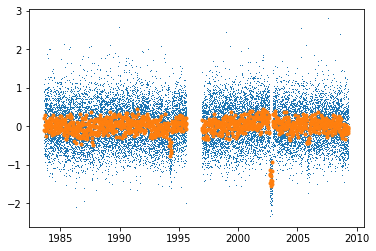

In [3]:
plt.plot(lc['time'][lc['mask']],lc['flux'][lc['mask']],',')

#Binning the lightcurve to 30mins
lc=tools.lcBin(lc,binsize=30/1440)

plt.plot(lc['bin_time'],lc['bin_flux'],'.')

[home](#contents)

## 2) Stellar Parameters

In `MonoTools.starpars` are multiple methods for estimating stellar parameters without needing to manually look them up.

The simplest is to run `starpars.getStellarInfoFromCsv`. 
This script searches the input catalogues that have been updated with Gaia. There is native support to download/search:
* TICv8 (Stassun et al) using Astroquery
* Kevin Hardegree-Ullman's table for K2 (https://ui.adsabs.harvard.edu/abs/2020ApJS..247...28H/abstract)
* Travis Berger's work for Kepler (Gaia-Kepler Stellar Properties Catalog, https://arxiv.org/abs/2001.07737)

In cases where the star is present in multiple source (e.g. a K2 object in the TIC), we check all possible source and take the value with the best-constrained stellar density. 
Similarly, if density is provided from multiple sources within the same table (e.g. a quoted $\rho_s$ value, plus $R_s$ & $M_s$, plus $R_s$ & $\log{\rm g}$), then we compute a weighted average to produce a constrained $\rho_s$.

In cases where the star is NOT present in those catalogues, `starpars.getStellarInfoFromCsv` will then try to scrape the initial input catalogue (e.g. Huber's EPIC and the KIC, both from the exoplanet archive).

Finally, in cases where no info can be found from any source, `starpars.getStellarInfoFromCsv` scrapes survey data for the star from Gaia, APAS, 2MASS, SDSS, etc, and calls a modified version of Dan Huber's `IsoClassify` module with that info to produce stellar parameters. This may requre an RA/Dec (in the form of an astropy `SkyCoord` object to be inputted.

In [4]:
#For K2-115:
info_tic,_,_ = starpars.getStellarInfoFromCsv(7020254,'tess')
info_epic,_,_ = starpars.getStellarInfoFromCsv(211442297,'K2')

Breaking because status = COMPLETE
211442297  not in TIC


In [5]:
print([info_tic[c] for c in ['rho','rad','mass','logg','source']],
      [info_epic[c] for c in ['rho','rad','mass','logg','source']])

[1.6462452320335064, 0.85554, 1.026, 4.58473, 'TICv8'] [1.290200785393436, 0.868, 0.89, 4.403, 'KHU_EPIC']


In [6]:
# and for our target star:

info,_,_ = starpars.getStellarInfoFromCsv(349488688,'tess')

Breaking because status = COMPLETE


In [34]:
[info[c] for c in ['rho','rad','mass','logg','source']]

[0.46116768966418153, 1.39619, 1.25, 4.24509, 'TICv8']

## 3) Searching the lightcurve for MonoTransits

Let's use `search.MonoTransitSearch` to try to find any potential transits.

There's quite a few different inputs, but the important ones are:
* Stellar parameters `Rs`, `Ms`, `Teff` - these are used to build transit models. For a quick way of getting stellar parameters, see <a href='starpars'> 7) Stellar Parameters </a>

* `mono_SNR_thresh` - the signal to noise limit to call the detections a candidate or not
* `use_binned` - this will speed up the search
* `use_poly` - co-fits a polynomial with the transit model. If this is False, make sure `use_flat` is True

349488688 - Searching 10671 positions with 5 durations: 0.111,0.207,0.292,0.373,0.45


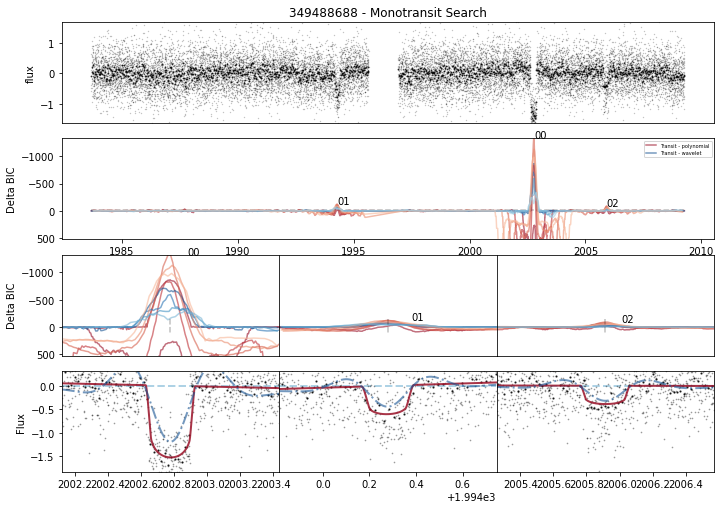

In [7]:
detns, outparams, fig_loc = search.MonoTransitSearch(lc, 349488688, 'tess', plot=True,
                                                     Rs=info['rad'],Ms=info['mass'],Teff=info['teff'],
                                                     use_stellar_dens=True,
                                                     mono_SNR_thresh=6.5,use_binned=True,use_poly=True)

In [8]:
#Detections are dictionaries of vital information for each monotransiting planet candidate:
print(detns.keys())
print(detns['00'])

dict_keys(['00', '01', '02'])
{'llk_trans': 87.40515464312568, 'llk_sin': -211.4933289319617, 'llk_poly': -575.6050678399336, 'BIC_trans': -160.5325752863603, 'BIC_sin': 434.0455160389463, 'BIC_poly': 1168.4960244733106, 'sin_DeltaBIC': -594.5780913253066, 'poly_DeltaBIC': -1329.028599759671, 'tcen': 2002.778531310588, 'period': nan, 'period_err': nan, 'DeltaBIC': -1329.028599759671, 'tdur': 0.29166367411259486, 'depth': 1.5276511173703724, 'orbit_flag': 'mono', 'snr': 9.401514971410847, 'P_min': 6.508630183133164}


## 3) Vetting MonoTransit candidates

In `search` there is a function to quickly fit a monotransit, taking only the lightcurve dict, the time of transit and the duration.

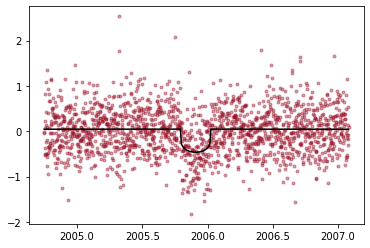

In [10]:
#Here
fitted_cand = search.QuickMonoFit(lc,detns['02']['tcen'],detns['02']['tdur'],fit_poly=True,
                                  polyorder=2, ndurs=4, how='mono')
plt.plot(fitted_cand['monofit_x'], fitted_cand['monofit_y'],'.',alpha=0.4)
plt.plot(fitted_cand['monofit_x'], fitted_cand['monofit_ymodel'],'-k')

We can also just pass the same info to `VetCand`. This will run:
* `QuickMonoFit`
* A check of the SNR (white) and SNR (red - e.g. using the noise at the specific transit duration).
* `VariabilityCheck` - a model comparison between the transit model, a variability model (e.g. sin wave) and a "Step model" (e.g. two polynomials and a step between).
* `AsteroidCheck` - a Gaussian fit to the background flux, which should spike if the dip is due to an asteroid pasing through the BG aperture
* `CentroidCheck` - a fit to the x and y centroids with the transit model and centroid shifts
* `CheckInstrumentalNoise` - a check of the number of transit-like features detected at this epoch (if in TESS)

In each case where the candidate fails a test, the `flag` field in the resulting dictionary is labelled with the type of false positive (e.g. 'asteroid','EB','instrumental').

If the candidate passes all tests, it will have the flag: `planet`

In [26]:
search.VetCand?

In [42]:
# We have some ideas where planet candidates are - let's not bias our flattening by including them. Hence:
tr_mask=tools.create_transit_mask(lc['time'],np.array([detns[v]['tcen'] for v in detns]),
                                  np.array([detns[v]['tdur'] for v in detns]))
lc=tools.lcFlatten(lc,transit_mask=tr_mask)

Earthshine model not useful in this case - polynomial model is better by 1.1440094657583208e-05
00 - Checks complete.  SNR: 37.35684  SNR_r: nan  variability: -213.105  centroid: -0.39798 | flag: planet
Earthshine model not useful in this case - polynomial model is better by 2.876530764459774e-05
01 - Checks complete.  SNR: 15.36271  SNR_r: nan  variability: -28.2318  centroid: -0.01096 | flag: planet
Earthshine model not useful in this case - polynomial model is better by 2.7751747208178064e-06
02 - Checks complete.  SNR: 10.96927  SNR_r: nan  variability: -26.2565  centroid: -0.04543 | flag: planet
{'00': 'planet', '01': 'planet', '02': 'planet'}


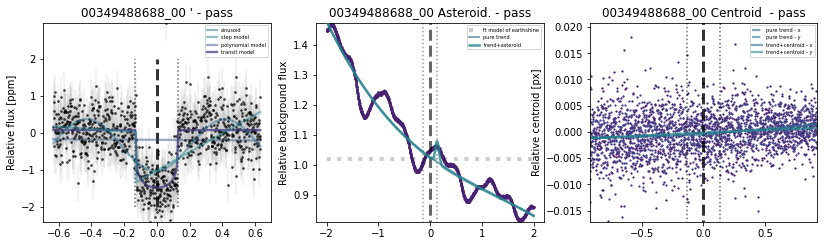

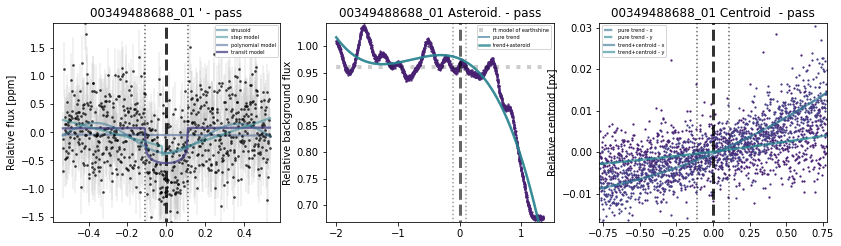

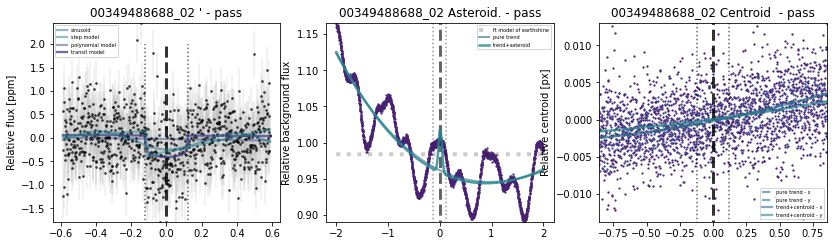

In [44]:
#Copying to remove links:
from copy import deepcopy
vetted_detns=deepcopy(detns)

#Looping over each candidate detection and running vetting:
for det in detns:
    vetted_detns[det], _ = search.VetCand(detns[det], det, 349488688, lc, mission='tess',mono_SNR_r_thresh=3,
                                          Rs=info['rad'],Ms=info['mass'],Teff=info['teff'], plot=True, transit_mask=tr_mask)
print({det:vetted_detns[det]['flag'] for det in vetted_detns})

In [64]:
[detns[k]['flag'] for k in detns]

['planet', 'planet', 'planet']

## 4) Periodic Planet Search

We also need to search the lightcurve for periodic candidates, as either the detected monos may be consistent with a periodic planet, or there may be another low-SNR planet in the system. We can do that with `PeriodicPlanetSearch`.

This uses `transitleastsquares` to search for periodic signals (e.g. planets with $\geq3$ transits). It then masks the detected signal and continues searching until no candidates with SNR greater than the threshold are found.

The inputs here are:
* lightcurve dict
* ID
* Dictionary of planets already detected (may be `{}`)
* `use_binned` - whether to bin data. TLS can be exceedingly slow with unbinned data. `binsize` sets the bin size.
* `use_flat` - unless the lightcurve is very flat already, we should flatted the lightcurve here
* `n_search_loops` - maximum number of times to mask candidates (if `mask_prev_planets`) and re-search the lightcurve
* `Rs`,`Ms`,`Teff` - stellar parameters used in TLS to create transit shapes
* `multi_SNR_thresh` - the SNR threshold for detection
* `plot` [boolean] and `plot_loc` - whether to plot and where to save that plot

Using TLS on ID=349488688 to search for multi-transiting planets
after flattening: 17203
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 38 durations
Searching 1172 data points, 1466 periods from 1.1 to 8.553 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: 91.21767488037104 -> 92.86328504852561


Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 38 durations
Searching 1172 data points, 1466 periods from 1.1 to 8.553 days
Using 1 of 12 CPU threads


optimizing logp for variables: [tcen, log_per, log_ror, mean]


0it [00:00, ?it/s]

message: Optimization terminated successfully.
logp: 128.5626223295419 -> 160.54993823249103
No handles with labels found to put in legend.


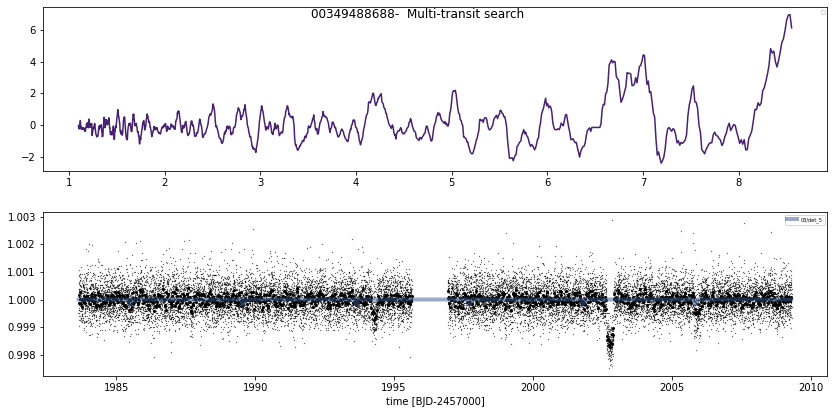

In [65]:
detns, _ = search.PeriodicPlanetSearch(lc, 349488688, detns, use_binned=False, use_flat=True, 
                                    binsize=30/1440.0, n_search_loops=5,
                                    Rs=info['rad'],Ms=info['mass'],Teff=info['teff'], multi_SNR_thresh=7.0,
                                    plot=True, plot_loc=None, mask_prev_planets=True)

We can also apply `search.VetCand` to periodic objects, although `AsteroidCheck` and `InstrumentalNoise` are not performed:

In [66]:
#performing a candidate vetting for periodic candidates:
for det in detns:
    if detns[det]['orbit_flag']=='periodic':
        #Only doing the vettng for periodic candidates:
        outdet, _ =search.VetCand(detns[det], det, 349488688, lc, mission='tess',
                                  Rs=info['rad'],Ms=info['mass'],Teff=info['teff'], plot=True)
        vetted_detns[det]=outdet


## 5) Identifying Confused Candidates

I mean two things by this:
* "Monotransits" which are in fact associated with one of the multi-transiting candidates found in the periodic search
* "Monotransits" which have two such candidates, making them "Duotransits" (but not necessarily with a certain period)

For the former, we can run `CheckPeriodConfusedPlanets`. This takes:
* `lc` - dict of light curve
* `all_dets` - dict of candidates
* `mono_mono` = True - whether to compare multis with each other
* `multi_multi` = True - whether to compare monos with each other
* `mono_multi` = True - whether to compare monos with multis
It produces a new dictionary of candidates, where those lower-SNR candidates which are confused with a higher-SNR sibling are reassigned from `flag='planet'` to `flag='confused'`

And for the latter, we use `CheckMonoPairs`. This loops through each monotransit with each other, comparing durations and depths, as well as seeing if such a pair is possible given the observed lightcurve. It takes as arguments:
* `lc_time` - the time array from the lightcurve
* `all_pls` - the dict of planet candidates
* `prox_thresh` = 3.5 - a rough SNR factor above which we consider two monotransits to be alike

In [67]:
# Checking for confusion between candidate period/epochs:
#final_detns, monos, multis = search.CheckPeriodConfusedPlanets(deepcopy(lc), deepcopy(vetted_detns))

# Here we also have monotransit pairs, so we must also check if they appear similar enough to constitute a duo with CheckMonoPairs
final_detns = search.CheckMonoPairs(lc['time'], deepcopy(vetted_detns))

In [68]:
#The detections that made it through:
{i:{key:final_detns[i][key] for key in ['flag','orbit_flag','period','tdur','tcen','depth']} for i in final_detns if final_detns[i]['flag']=='planet'}

{'00': {'flag': 'planet',
  'orbit_flag': 'mono',
  'period': 19.85241335697991,
  'tdur': 0.2636240272786203,
  'tcen': 2002.7706840416433,
  'depth': 1.5601378437801263},
 '01': {'flag': 'planet',
  'orbit_flag': 'duo',
  'period': 11.63377464288692,
  'tdur': 0.23367232775640628,
  'tcen': 1994.2804336949716,
  'depth': 0.6236105714556889}}

In [69]:
#And those detections that were removed:
{i:{key:final_detns[i][key] for key in ['flag','orbit_flag','period','tdur','tcen','depth']} for i in final_detns if final_detns[i]['flag']!='planet'}

{'02': {'flag': 'FP - confusion',
  'orbit_flag': 'FP - Confusion with 01',
  'period': 22.662335178511853,
  'tdur': 0.24474450235048695,
  'tcen': 2005.9142083378586,
  'depth': 0.4580166189178828}}